In [1]:
    #General
import pandas as pd
import numpy as np


    #Plotting
import matplotlib.pyplot as plt
import seaborn as sns

    #nltk and regex packages
import regex as re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


    #Sklearn Packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words, text

%config InlineBackend.figure_format = 'retina'

/Users/rwilkening/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


---
---
---

# Cleaning and Formatting Data

---
---
---

#### Read in scrape csv

In [2]:
df = pd.read_csv('./reddit_scrape_df.csv')
df.head()

,created_utc,title,selftext,subreddit
0,1580515632,How do you muster up the courage to ask a girl...,[removed],AskMen
1,1580515616,Do men feel it if a condom accidentally falls ...,[removed],AskMen
2,1580515485,"Men, do you feel it if a condom accidentally f...",[removed],AskMen
3,1580515429,A girl you are dating says she had anxiety abo...,NaN,AskMen
4,1580515379,"Men whose advice I desperately need, how often...",Help PLSSSSS,AskMen


#### Checking the size of the data frame

In [3]:
df.shape

(20000, 4)

#### Changing `AskMen` and `AskWomen` to 0 and 1, Respectively

In [4]:
df['subreddit_target'] = df['subreddit'].replace({"AskMen": 0, "AskWomen":1})

#### Checking for duplicate rows, there are none

In [5]:
#Adapted from classmate Pete Plass

df.drop_duplicates().shape

(19996, 5)

#### Removing Where Posts Have Been `[removed]`

In [6]:
df.replace("[removed]", "", inplace = True)

#### Created a new column with `selftext` and `title` text

In [7]:
df['all_text'] = df['title'] + " " + df['selftext'] + " "

#### Updating Data Frame to Only Have Necessary Columns

(So that when we drop nulls we're only dropping the rows that affect modeling)

In [8]:
df = df[['subreddit_target', 'all_text']]
df.head()

,subreddit_target,all_text
0,0,How do you muster up the courage to ask a girl...
1,0,Do men feel it if a condom accidentally falls ...
2,0,"Men, do you feel it if a condom accidentally f..."
3,0,NaN
4,0,"Men whose advice I desperately need, how often..."


#### Dropping Nulls

In [9]:
df.isnull().sum()

subreddit_target       0
all_text            5539
dtype: int64

In [10]:
df.dropna(axis = 0, inplace=True)

In [11]:
df.isnull().sum()

subreddit_target    0
all_text            0
dtype: int64

## Cleaning Text

#### Removing Extra an Weird Things

In [12]:
#Adapted from Instructor Hovanes

df['all_text'] = df['all_text'].map(lambda x: re.sub('\/\/', ' ', x)) # Removing line breaks
df['all_text'] = df['all_text'].map(lambda x: re.sub('[\\][\']', '', x)) # Removing apostrophes
df['all_text'] = df['all_text'].map(lambda x: re.sub('[^\w\s]', ' ', x)) # Removing all punctuation 
df['all_text'] = df['all_text'].map(lambda x: re.sub('\xa0', ' ', x)) # removing xa0
df['all_text'] = df['all_text'].map(lambda x: re.sub('\n', ' ', x)) # removing line break
df['all_text'] = df['all_text'].map(lambda x: re.sub('\s[\/]?r\/[^\s]+', ' ', x)) # removing mentions of any subreddit
df['all_text'] = df['all_text'].map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x)) # removing urls
df['all_text'] = df['all_text'].map(lambda x: re.sub("[^a-zA-Z]", " ", x)) # Only keeping letters

#### Making all the text lower case

In [13]:
df['all_text'] = df['all_text'].str.lower()

---
---
---

## Tokenizing

---
---
---

In [14]:
tokenizer = RegexpTokenizer(r'\s+', gaps=True)

#### Tokenizing Posts for `Women` and `Men`

In [15]:
women_post_tokens = [tokenizer.tokenize(posts) for posts in df[df['subreddit_target'] ==1]['all_text'] ]
men_post_tokens = [tokenizer.tokenize(posts) for posts in df[df['subreddit_target'] ==0]['all_text'] ]

#### `ask_women` Tokenizing all text

In [18]:
women_text = ''

for post in df[df['subreddit_target'] == 1 ]['all_text']:
    women_text += ' ' + post
    
    
men_text = ''

for post in df[df['subreddit_target'] == 0 ]['all_text']:
    men_text += ' ' + post

In [19]:
women_tokens = tokenizer.tokenize(women_text)
men_tokens = tokenizer.tokenize(men_text)

---

## Exploring Tokenized Text

---

#### All the text in `ask_men` 

It takes a while to load, so only uncomment if you're particularly interested. 

In [20]:
# women_text

#### Word Count for  `women_text`

In [21]:
len(women_text)

1318743

#### Word count for post in `ask_men`

In [22]:
len(men_text)

2178396

#### All the text in `ask_men` 

It takes a while to load, so only uncomment if you're particularly interested. 

In [23]:
# men_text

In [24]:
df

,subreddit_target,all_text
0,0,how do you muster up the courage to ask a girl...
1,0,do men feel it if a condom accidentally falls ...
2,0,men do you feel it if a condom accidentally f...
4,0,men whose advice i desperately need how often...
5,0,men of reddit how do you feel about women s w...
...,...,...
19992,1,my wife shares her period cycle with my mil i...
19993,1,women how do you handle loneliness even after ...
19995,1,how do you tell your s o a secret about yourse...
19997,1,how do i control my anger


---
---
---

# Lemmatizing

---
---
---

In [25]:
lemmatizer = WordNetLemmatizer()

####  Lemmatizing `ask_women` and `ask_men`

In [26]:
men_lemmas = [lemmatizer.lemmatize(tokes) for tokes in men_tokens]
women_lemmas = [lemmatizer.lemmatize(tokes) for tokes in women_tokens]

#### How many unique words are in the men_lemmas

In [27]:
len(men_lemmas)

419793

#### How many unique words are in the women_lemmas

In [28]:
len(women_lemmas)

250299

---
---
---

# Count Vectorizer

---
---
---

#### Creating a Seperate DataFrames for `Ask_Men` and `Ask_Women`

In [29]:
women_df = df[df['subreddit_target'] == 1]
men_df = df[df['subreddit_target'] ==0]

In [30]:
women_df.subreddit_target.value_counts()

1    6984
Name: subreddit_target, dtype: int64

In [31]:
men_df.subreddit_target.value_counts()

0    7477
Name: subreddit_target, dtype: int64

#### Adding Customl Stop Words to Count Vectorizer

In [32]:
cus_stops = stopwords.words()
my_cus_stops = cus_stops + [
    'like', 'just', 'im', 'dont','things', 'thing', 'make', 'don', 'does', 've', 'com', 'https', 'cause', 
    'amp', 'usually', 'super', 'knew', 'longer', 'happens', 'along','does,', 'ill', 'lol', 'using', 'wanna', 
    'however''time','person','year','way','day','thing','man','world','life','hand','part','child','eye','woman','place',
    'work','week','case','point','company','number',"be","have","do","say","get","make","go","know","take","see",
    "come","think","look","want","give","use","find","tell","ask","work","seem","feel","try","leave","call","good",
    "new","first","last","long","great","little","own","other","old","right","big","high","different","small","large",
    "next","early","young","few","public","bad","same","able","to","of","in","for","on","with","at","by",
    "from","up","about","into","over","after","the","and","a","that","I","it","not","he","as","you","this","but",
    "his","they","her","she","or","an","will","my","one","all","would","there","their", 'is', 'me', 'what', 'how', 'so', 
    'was', 'your', 'if', 'are', 'we','out', 'when', 'men', 'him', 'really', 'can', 'been', 'who', 'time', 'did', 
    'now', 'them', 'women', 'even', 'its', 'being','no', 'ive', 'should', 'were', 'something', 'people','never', 
    'back', 'always', 'then', 'much', 'going', 'someone', 'years','still', 'ever', 'also','guys', 'some', 
    'had', 'more', 'girl', 'am', 'because', 'why', 'has',
    'than','got', 'very', 'only', 'said', 'too', 'reddit','where', 'off', 'myself', 'need', 'most', 'girls', 
    'could','anything', 'before', 'which', 'while', 'around', 'told', 'any', 'told', 'since', 'talk','our', 'best', 'getting',
    'having', 'anyone', 'made', 'lot', 'looking','talking', 'question', 'well', 'down', 'started', 'again', 'months',
    'together', 'without', 'better', 'asked', 'doing', 'here','pretty', 'times', 'many', 'cant', 'didnt', 'interested', 'every',
    'bit', 'else', 'etc', 'actually', 'start', 'trying', 'each', 'each', 'hard', 'went','whats', 'through', 
    'both', 'keep', 'kind', 'sure', 'thought', 'wanted', 're', 'two', 'us', 'let', 'recently', 'thinking', 
    'doesnt', 'another', 'ago','makes', 'hes', 'often', 'feelings', 'maybe', 'these', 'away', 'feeling', 'those',
    'asking','stuff', 'sometimes', 'end', 'deal', 'stop', 'night', 'met','situation', 'nothing', 'text', 'felt', 'normal',
    'once', 'care', 'mean', 'mind', 'found', 'during', 'nice',  'saying', 'please', 'shes','seems',
    'like', 'just', 'im', 'know', 'really', 'think', 'did', 'dont', 'make', 'things', 'good', 'does', 'life', 
    'way',   'ive', 'don', 've', 'going', 'day', 'work', 'said',  'reddit', 'got',  'need', 'man', 'say', 'best', 
    'ask','any', 'guy','women', 'like', 'just', 'know', 'im', 'feel', 'want', 'time', 'did','really', 'guy', 
    'think', 'dont', 'make', 'does', 'men', 'things', 'good', 'way', 'life', 'man', 'reddit','people', 
    'need', 'best', 'work', 'said', 'don', 've', 'going', 'girls', 'day', 'got', 'ask', 'having', 'guys',
    'question']

#### Instantiating CountVectorizer as `cvec`

In [33]:
cvec = CountVectorizer(stop_words= my_cus_stops, min_df=5)

#### Count Vectorizing For `men_df`, `women_df` and the whole data frame and saving as their own variable respectively 

In [34]:
#Ask Men
  
    
    #Fit and transform
men_cvec_matrix = cvec.fit_transform(men_df['all_text'])

    #Convert to DataFrame
men_cvec_df = pd.DataFrame(men_cvec_matrix.toarray(),
                          columns=cvec.get_feature_names())



#Ask Women

    #Fit and transform
women_cvec_matrix = cvec.fit_transform(women_df['all_text'])

    #Convert to DataFrame
women_cvec_df = pd.DataFrame(women_cvec_matrix.toarray(),
                          columns=cvec.get_feature_names())



#For Both

    #Fit and transform
cvec_matrix = cvec.fit_transform(df['all_text'])

    #Convert to DataFrame
cvec_df = pd.DataFrame(cvec_matrix.toarray(),
                          columns=cvec.get_feature_names())

/Users/rwilkening/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳол', 'ҳолате', 'әттеген', 'ӯим', 'अक', 'अग', 'अझ', 'अन', 'अर',

#### Pulling the most common words for `ask_men` `ask_women` and all

In [35]:
# #ask men
top_men_word_counts = men_cvec_df.sum().sort_values(ascending=False).head(50)
low_men_word_counts = men_cvec_df.sum().sort_values(ascending=True).head(50) 

#ask women
top_women_word_counts = women_cvec_df.sum().sort_values(ascending=False).head(50)
low_women_word_counts = women_cvec_df.sum().sort_values(ascending=True).head(50) 

#all
top_word_counts = cvec_df.sum().sort_values(ascending=False).head(50) 
low_word_counts = cvec_df.sum().sort_values(ascending=True).head(50) 

#### Top Words in AskMen

In [36]:
top_men_word_counts

friends          847
sex              807
relationship     731
love             559
help             556
friend           550
dating           535
date             520
advice           443
girlfriend       417
school           310
job              283
hair             269
ex               263
boyfriend        255
days             242
attractive       241
male             239
home             236
past             233
weird            225
partner          221
wrong            205
meet             204
experience       201
female           200
wants            196
wondering        194
enough           192
social           192
tried            192
post             189
self             186
problem          186
used             185
gf               185
though           185
relationships    184
porn             181
almost           181
live             180
couple           176
sexual           176
conversation     176
shit             175
everything       175
put              175
dick         

#### Top Words in AskWomen

In [37]:
top_women_word_counts

sex              483
relationship     463
friends          461
help             422
ladies           417
friend           412
love             406
advice           370
dating           306
date             303
partner          248
hair             235
period           235
experience       226
girlfriend       203
female           200
boyfriend        190
attractive       182
days             166
male             159
body             159
thoughts         153
sexual           148
job              146
past             144
home             142
self             139
ex               137
school           136
control          134
family           130
birth            130
weird            123
though           122
put              122
post             121
move             119
married          118
wrong            118
wants            117
wondering        117
curious          115
less             115
done             114
tried            110
relationships    109
thanks           108
everything   

#### Top Words in AskWomen

In [38]:
top_word_counts

friends          1308
sex              1290
relationship     1194
help              978
love              965
friend            962
dating            841
date              823
advice            813
girlfriend        620
hair              504
partner           469
school            446
boyfriend         445
ladies            441
job               429
experience        427
attractive        423
days              408
ex                400
female            400
male              398
home              378
past              377
weird             348
self              325
sexual            324
wrong             323
body              314
wants             313
wondering         311
meet              310
post              310
though            307
thoughts          303
tried             302
put               297
family            296
relationships     293
period            292
used              290
enough            288
move              284
everything        283
social            283
curious   

---
---
---

# Sentiment

---
---
---

#### Instantiating Sentiment Analyzer

In [39]:
sia = SentimentIntensityAnalyzer()

#### Defining a Function that gets the Sentiment Score of Each Post

In [40]:
def get_compound_sentiment(post):
    return sia.polarity_scores(post)['compound']

#### Creating a New Column with Sentiment Scores

In [41]:
df['sentiment'] = df['all_text'].apply(get_compound_sentiment)

#### Average Overall Sentiment Score

In [42]:
df['sentiment'].mean()

0.15988025032846911

#### Average Sentiment Score By Subreddit

0: Ask Men
    
1: Ask Women

In [43]:
df.groupby('subreddit_target')[['sentiment']].mean()

,sentiment
subreddit_target,
0,0.172235
1,0.146654


#### Basic Stats For Sentiment Score

0: Ask Men
    
1: Ask Women

In [44]:
df.groupby('subreddit_target')['sentiment'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit_target,,,,,,,,
0,7477.0,0.172235,0.524052,-0.9984,-0.15,0.0,0.6369,0.9999
1,6984.0,0.146654,0.464227,-0.9957,0.00,0.0,0.4939,0.9995


#### Posts with Strongest Negative Sentiment Scores for `Ask_Men`

In [45]:
df[df['subreddit_target'] == 0].sort_values('sentiment').head(20)

,subreddit_target,all_text,sentiment
6845,0,immense guilt after breakup with needy girlfri...,-0.9984
8052,0,ex gf signed on to live with me then dumped me...,-0.9974
2926,0,how do u deal with threats and harrassment i ...,-0.9970
8544,0,fellas why does it always gotta be so hard ou...,-0.9968
7102,0,it really hurts to see that importance given t...,-0.9968
5782,0,do men find tears crying very alarming so ive...,-0.9959
8717,0,should i move back to my hometown im going a ...,-0.9959
2050,0,how can i fix things with my girlfriends paren...,-0.9958
1289,0,how do i get over being mad at my dad so my p...,-0.9957
4176,0,got myself into a bad situation at school and ...,-0.9937


#### Post with Strongest Negative Sentiment Scores for `Ask_Women`

In [46]:
df[df['subreddit_target'] == 1].sort_values('sentiment').head(20)

,subreddit_target,all_text,sentiment
15621,1,to women who game what game community made yo...,-0.9957
19105,1,do i love women fucking fake depressed chads...,-0.9940
12651,1,is this considered relationship so i had a cr...,-0.9928
10125,1,what do i do i ve been struggling with depress...,-0.9920
14192,1,ladies how do you open up to someone especia...,-0.9902
17759,1,moms of reddit help question for mothers with...,-0.9902
17546,1,a friend once told me she had really painful s...,-0.9888
15933,1,how much destruction is too much so is dealin...,-0.9888
19351,1,is man spreading a really that bad so i was ju...,-0.9878
11223,1,what are your thoughts on kobe bryants death ...,-0.9870


#### Post with Strongest Positive Sentiments Score for `Ask_Men`

In [47]:
df[df['subreddit_target'] == 0].sort_values('sentiment', ascending=False).head(20)

,subreddit_target,all_text,sentiment
7000,0,developing an entourage social circle amp ...,0.9999
4112,0,what should i do with this girl which option ...,0.9997
8849,0,is the grass ever greener hi all i m a...,0.9995
5971,0,how to make lasting male friendships in your l...,0.9994
7998,0,do i move on or give him the benefit of the do...,0.9993
4146,0,how to deal with a distant friend first of ...,0.9989
4737,0,i ve been blocked by my ex girlfriend for abou...,0.9989
5450,0,should i marry her i love this girl but i m ...,0.9989
9473,0,what are your best ideas for improving your qu...,0.9987
8898,0,is he really interested single fathers answ...,0.9987


#### Post with Strongest Sentiment Score for `ask_women`

In [48]:
df[df['subreddit_target'] == 1].sort_values('sentiment', ascending=False).head(20)

,subreddit_target,all_text,sentiment
19442,1,i m feeling brave but as part of my resolve ...,0.9995
15685,1,help i might have posted this somewhere else b...,0.9994
19751,1,should i visit my guy friend who i may or may...,0.9989
15830,1,getting gift clothing for sister need advic...,0.9985
10068,1,honest opinion on my first love story i just w...,0.9984
11559,1,women of reddit how did you distinguish betwe...,0.9984
13642,1,i have never told anyone the full story of me ...,0.9983
12781,1,is this going anywhere do you think i met thi...,0.9980
11504,1,is this whole nice guy thing exaggerated gree...,0.9979
12597,1,normal for a guy to not last long when giving ...,0.9979


#### Checking for Outliers and General Distribution of Overall Sentiment

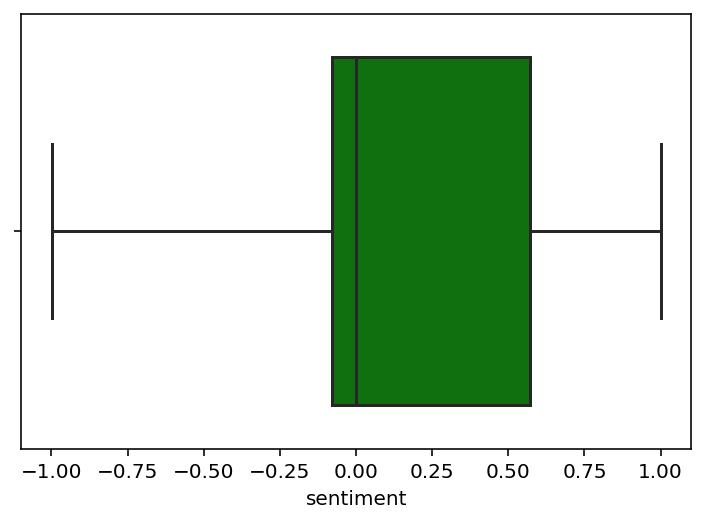

In [49]:
sns.boxplot(df['sentiment'], color = 'green');

#### Plotting a Distribution For Sentiment Scores for `Ask_Men` and `Ask_Women`

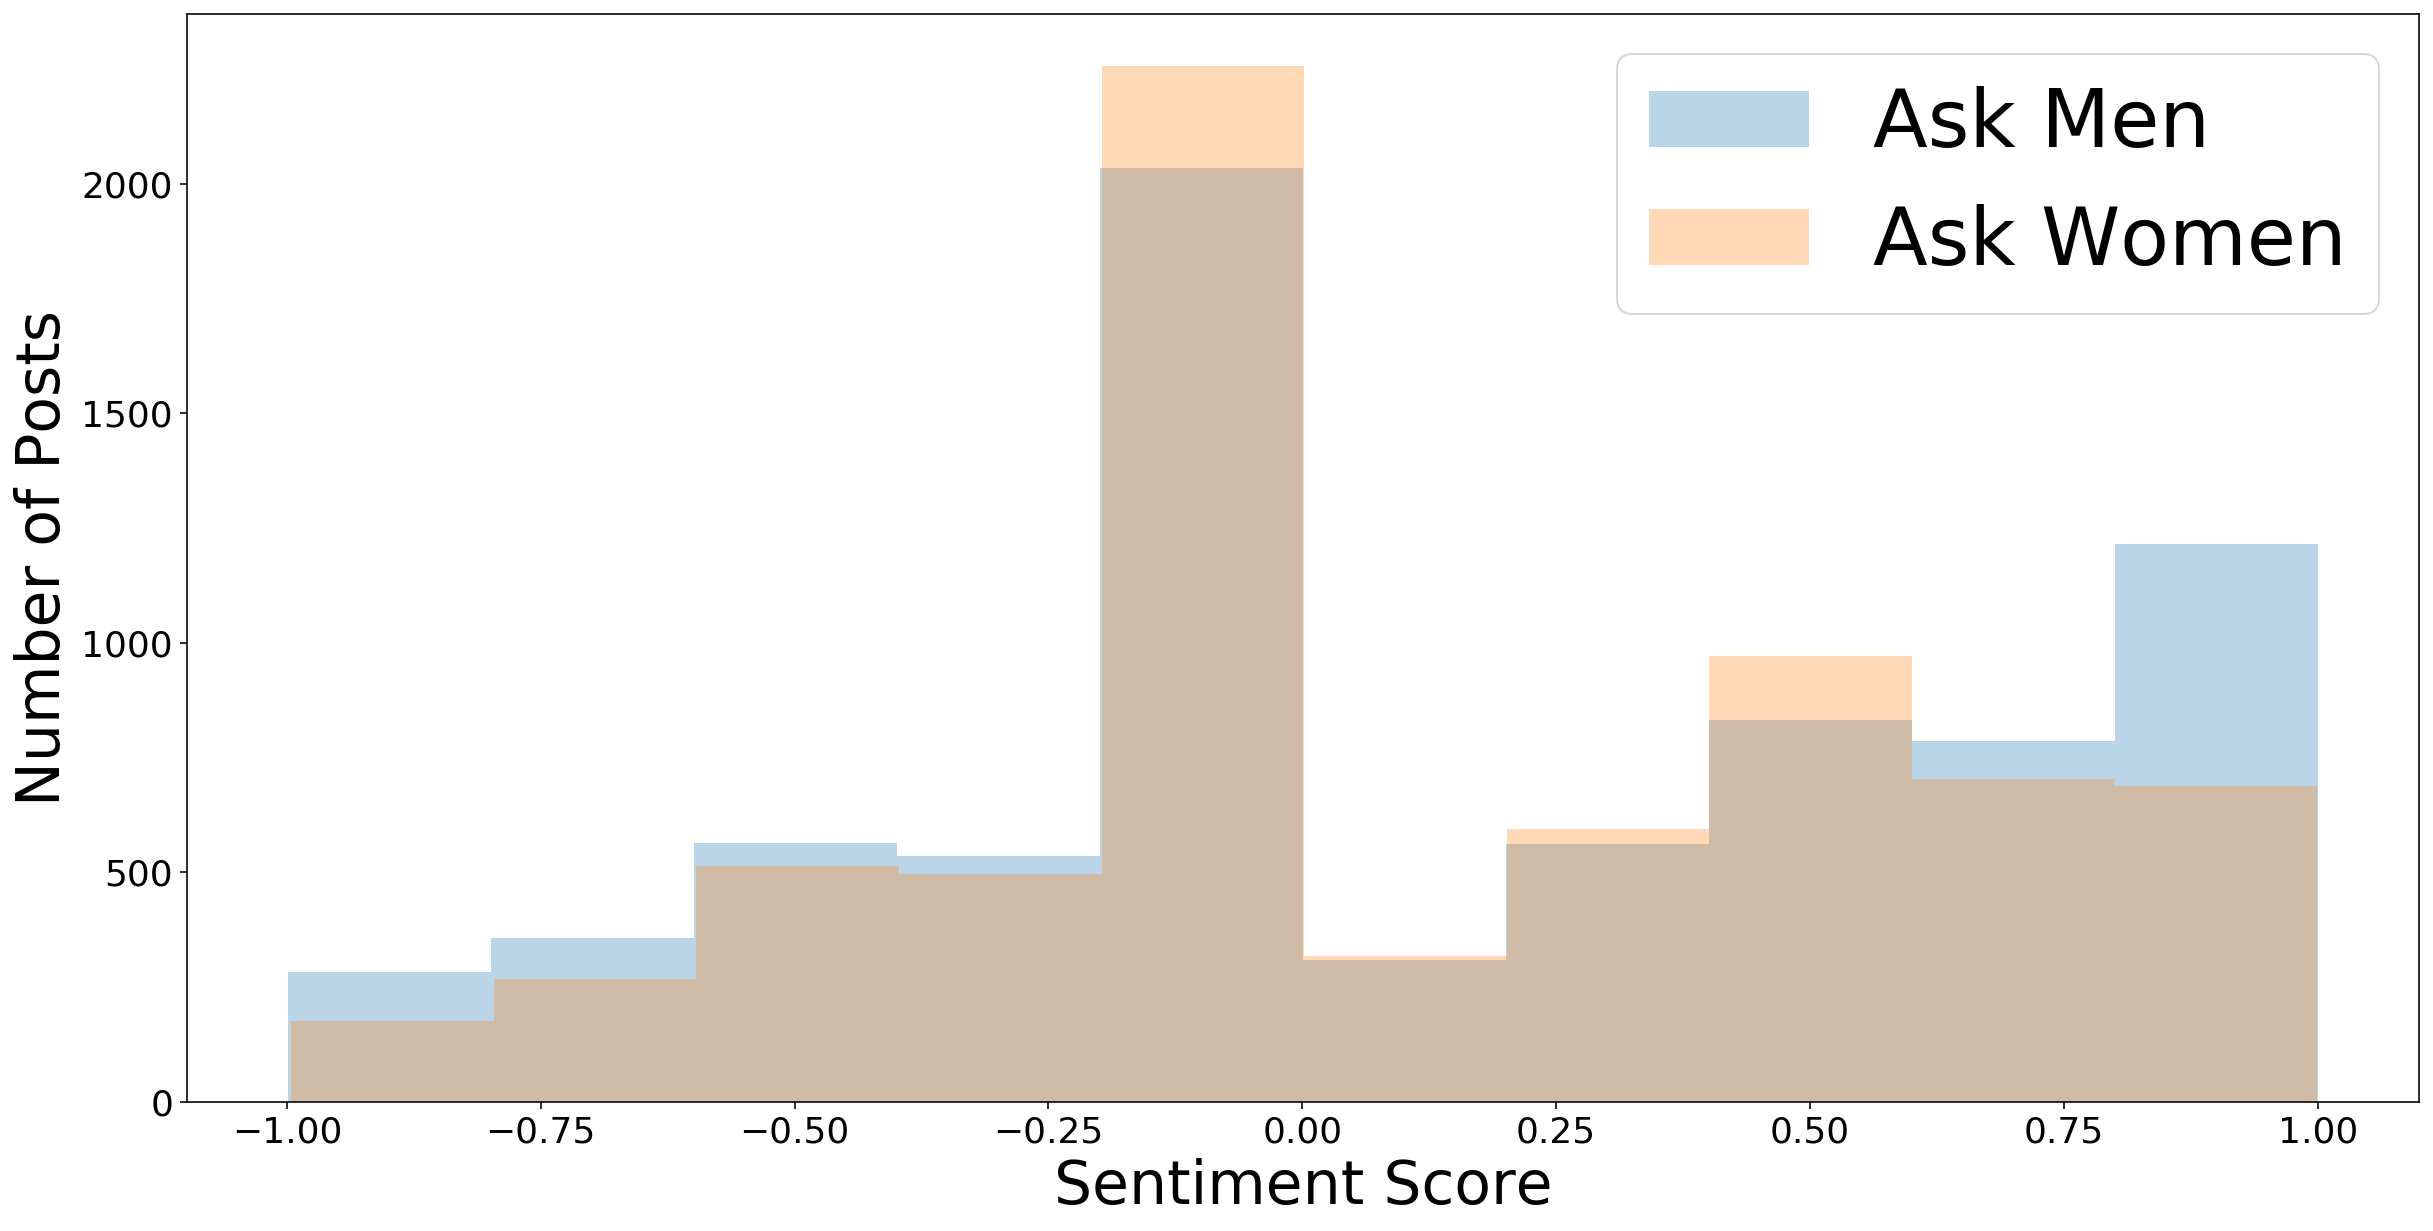

In [50]:
plt.figure(figsize=(20,10))


df.groupby('subreddit_target')['sentiment'].plot(kind='hist', alpha = 0.3);

plt.legend(['Ask Men', 'Ask Women'], prop={'size': 40});
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

plt.ylabel('Number of Posts', fontsize=30)
plt.xlabel('Sentiment Score', fontsize=30);


#### Over all Distribution of Sentiment Scores

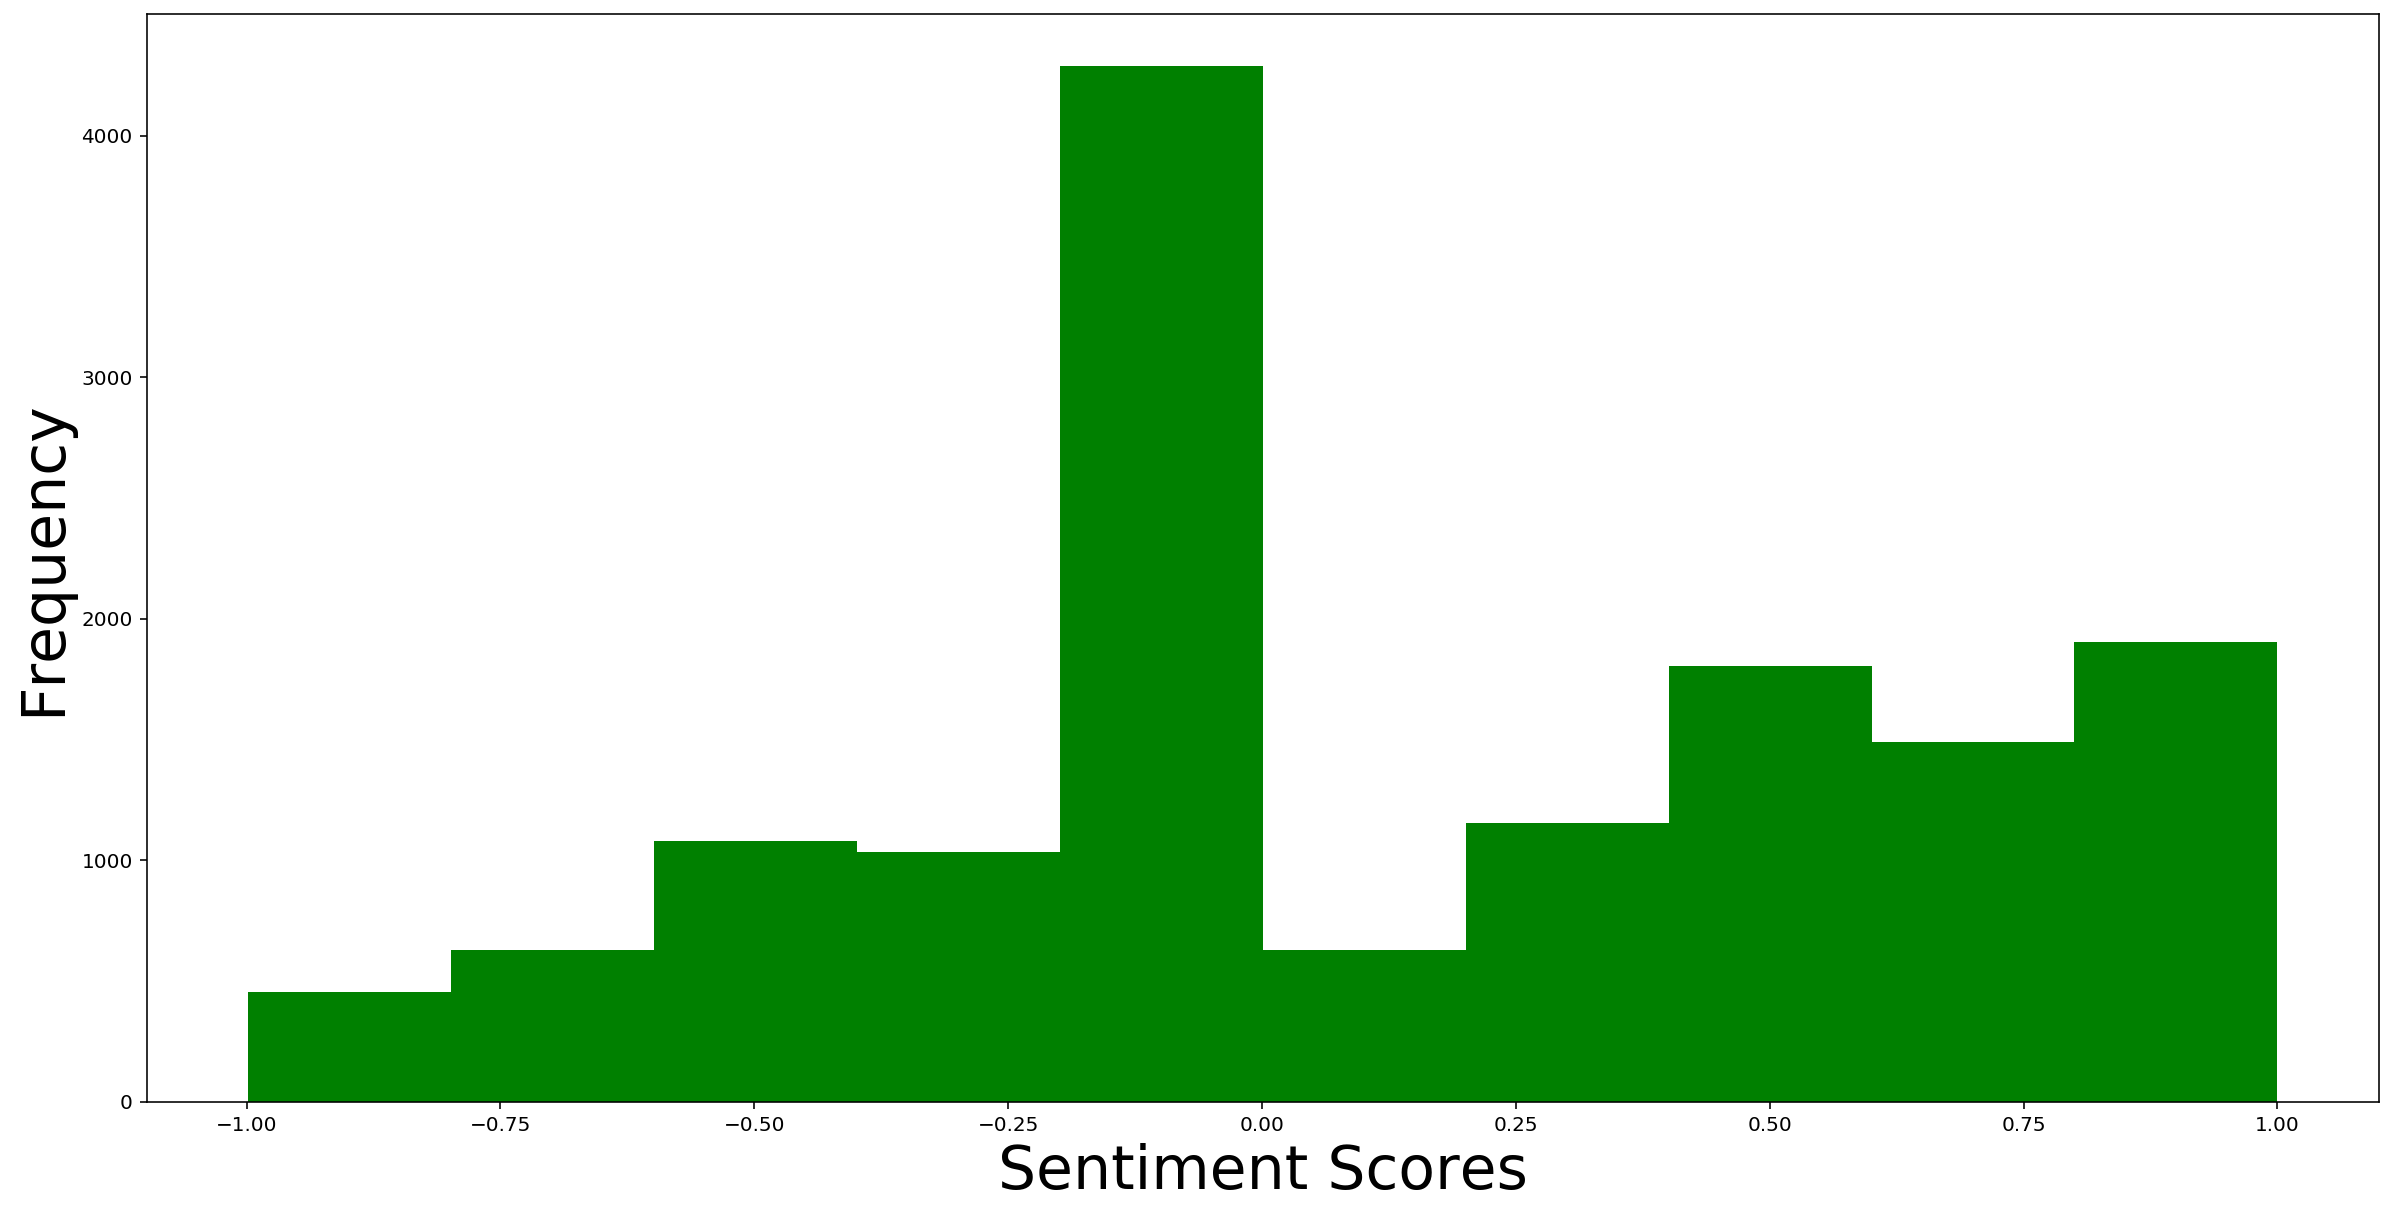

In [51]:
plt.figure(figsize=(20,10))


df['sentiment'].plot(kind='hist', alpha = 1, color='green');
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Sentiment Scores', fontsize=30);

#### Over all check for Outliers, Distributions, and Quartile for Sentiment Scores

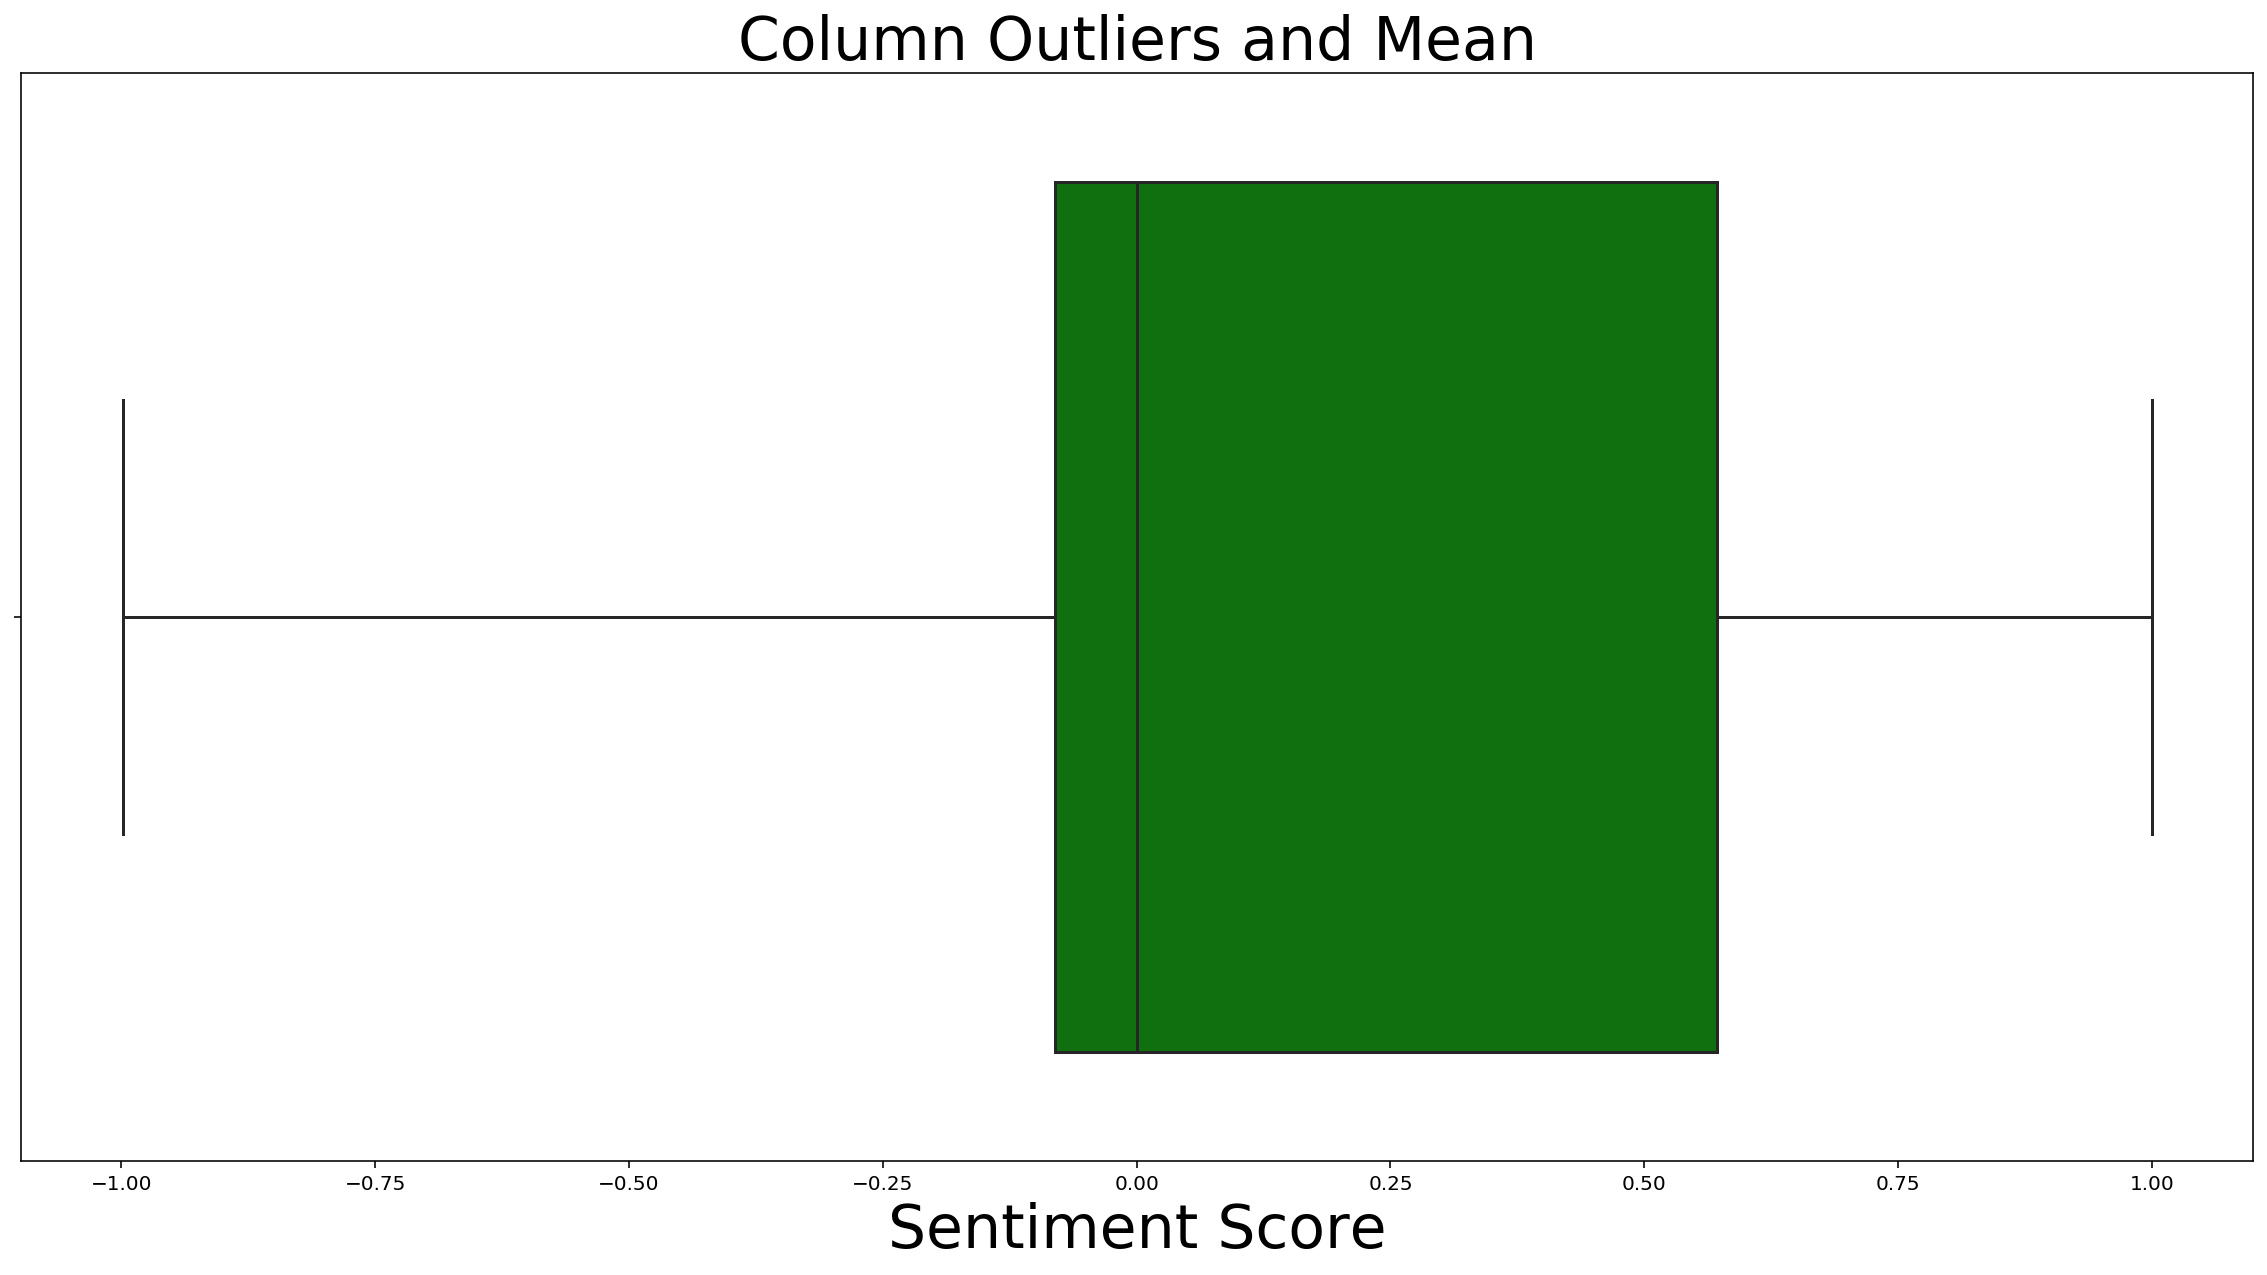

In [52]:
plt.figure(figsize=(20,10))


sns.boxplot(x=df['sentiment'],  color='green');
plt.title("Column Outliers and Mean", fontsize = 30);
plt.xlabel("Sentiment Score", size = 30);

---
---
---

# Word Count Per Posts

---
---
---

#### Creating a Column with Word Count for Posts

In [53]:
df['count'] = df.all_text.map(lambda x: len(x.split()))

#### Average Word Count Per Posts 

o: Ask Men

1: Ask Women

In [54]:
df.groupby('subreddit_target')[['count']].mean()

,count
subreddit_target,
0,56.144577
1,35.838918


#### Plotting the Frequency Of Words Per Post

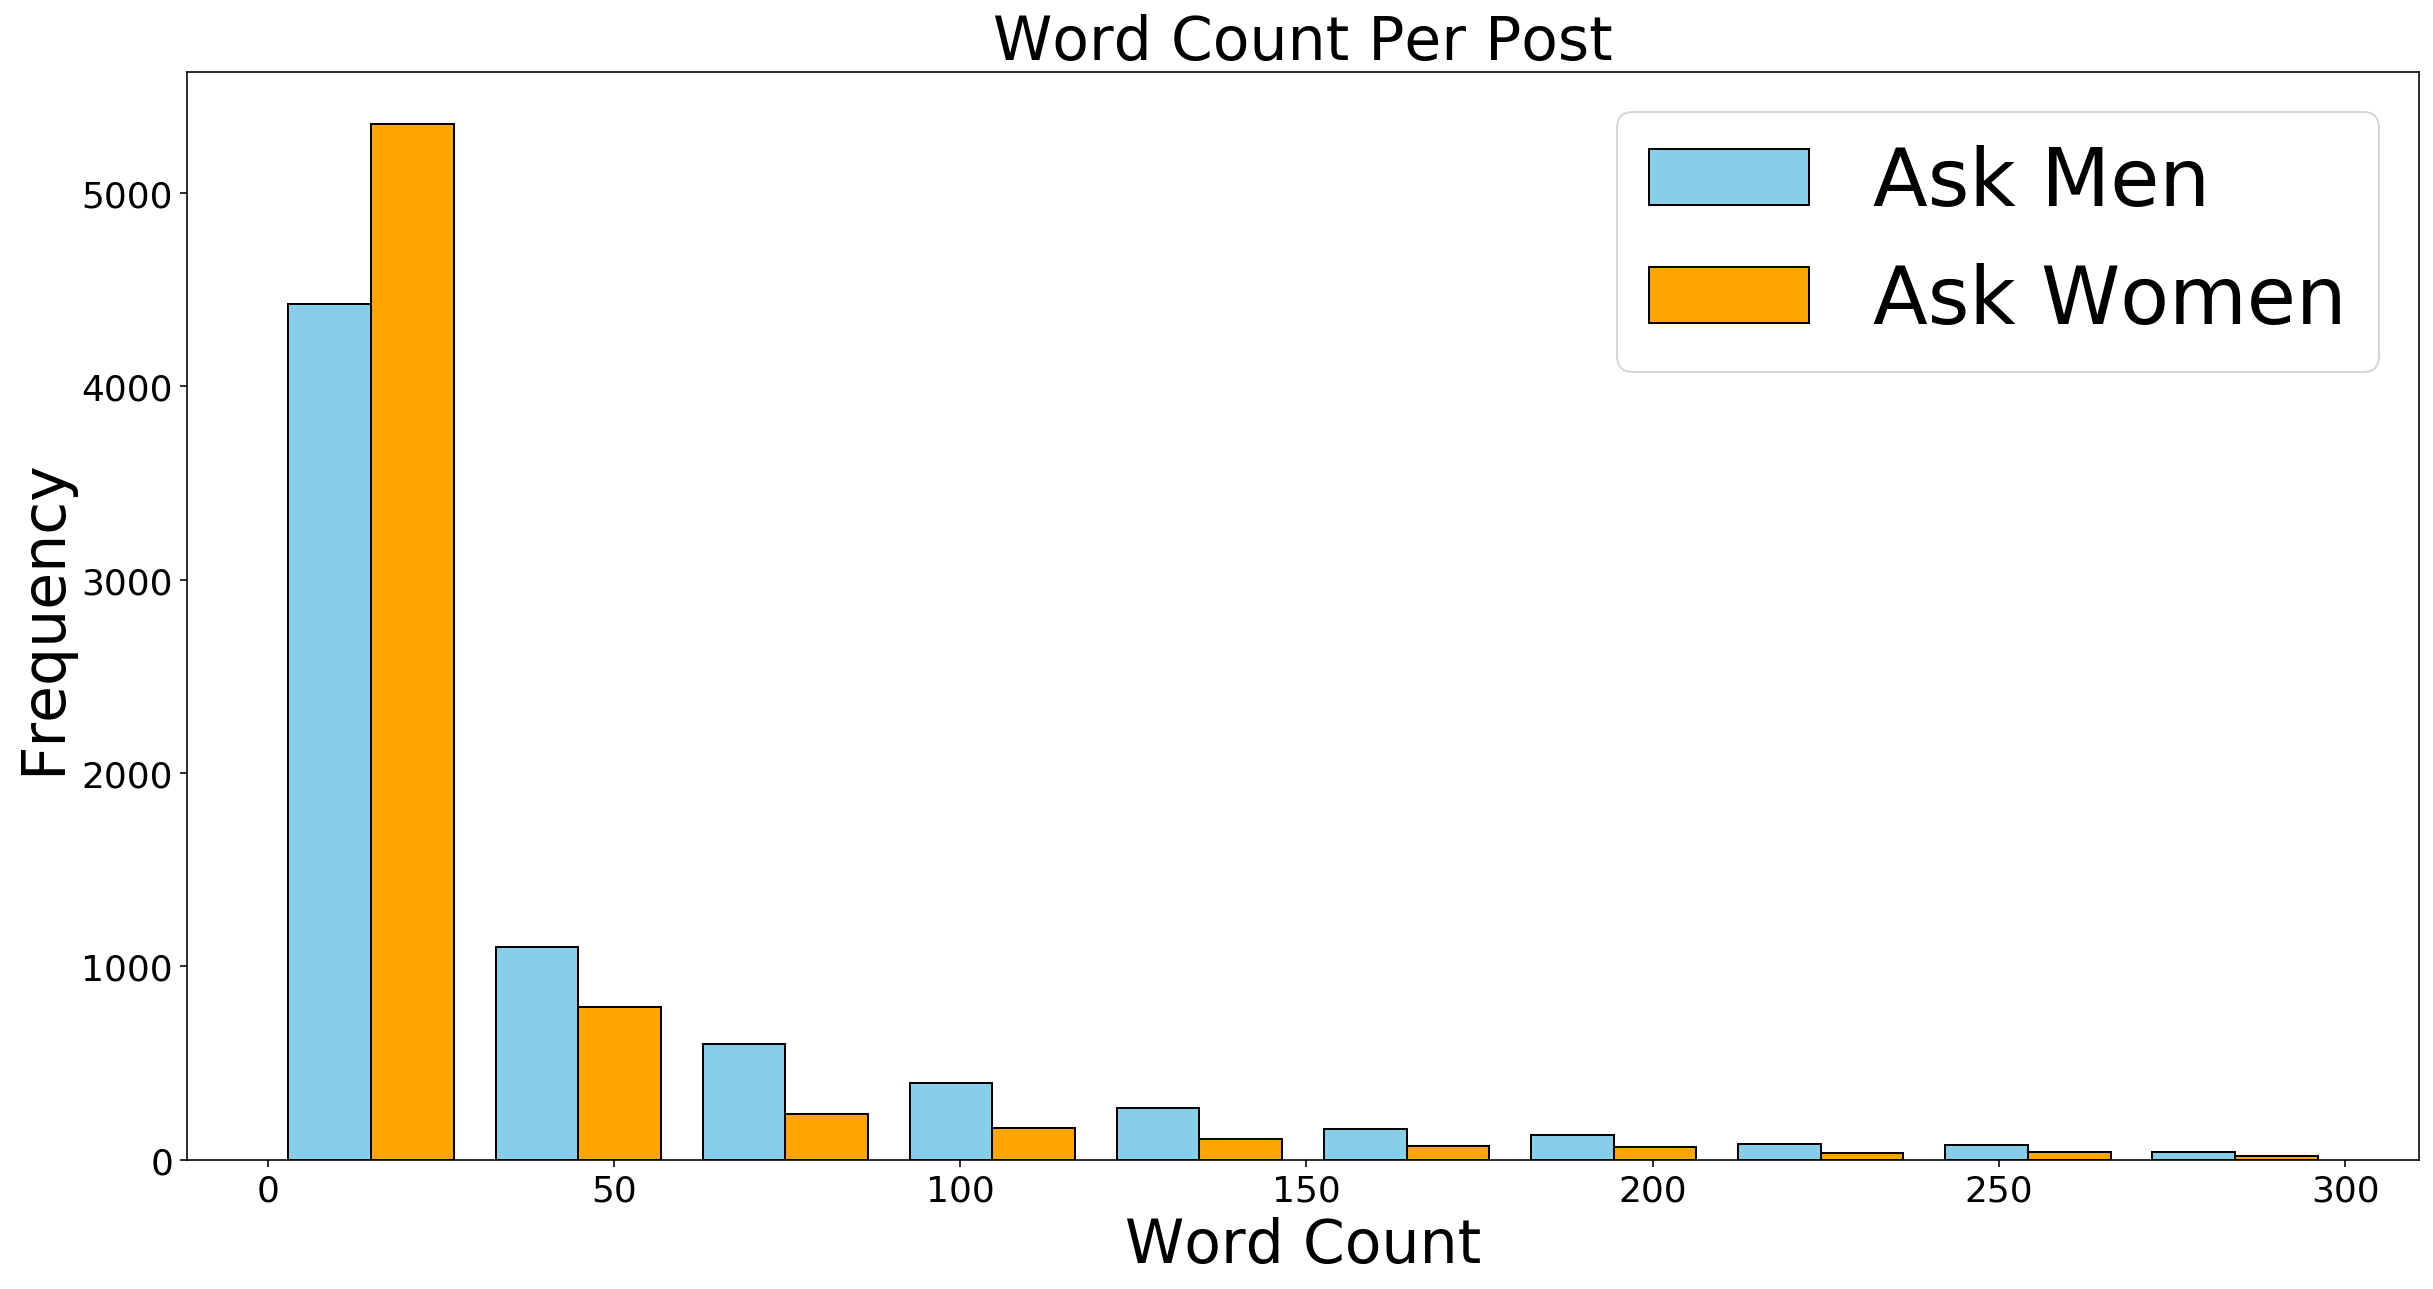

In [55]:
count_mask = (df['count'] < 300)
man_mask = (df['subreddit_target'] == 0)
woman_mask = (df['subreddit_target'] == 1)


plt.figure(figsize=(20,10))
plt.hist([df[man_mask & count_mask]['count'], 
          df[woman_mask & count_mask]['count']],
         bins=10, color=['skyblue', 'orange'], ec='k')
plt.title('Word Count Per Post', fontsize=30)
plt.legend(['Ask Men', 'Ask Women'], prop={'size': 40});
plt.ylabel('Frequency', fontsize =30);
plt.xlabel('Word Count', fontsize =30);

plt.yticks(fontsize=18)
plt.xticks(fontsize=18);

#### Exporting to csv for Modeling

In [58]:
df.to_csv('./2_modeling_csv', index = False)

---
---
---

# <span style = 'color:green'> To the Modeling Notebook!